# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Manuf portfolio

#### Lấy dữ liệu của Manuf porfolio

In [4]:
series <- ts(data = data$Manuf, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-27.3500  -1.7400   1.2750   0.9742   4.0200  17.3300 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

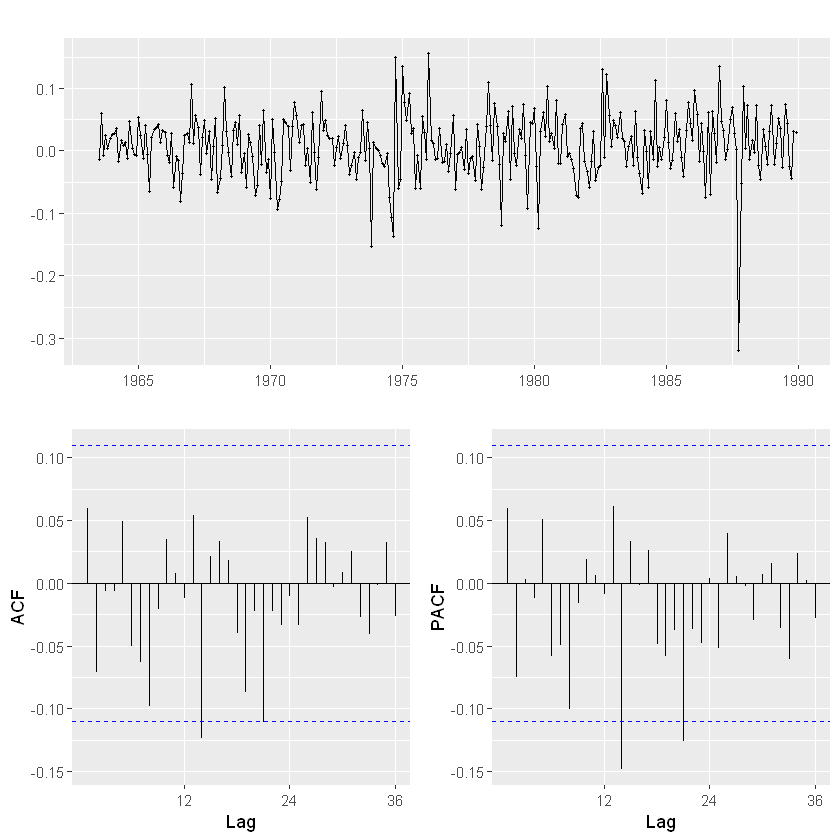

In [9]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [10]:
series_train %>% ndiffs()

[1] 0

In [11]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [12]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1    mean
      -0.8197  0.8872  0.0080
s.e.   0.1174  0.0937  0.0029

sigma^2 estimated as 0.002588:  log likelihood=497.38
AIC=-986.75   AICc=-986.63   BIC=-971.71


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with non-zero mean
Q* = 20.763, df = 21, p-value = 0.4735

Model df: 3.   Total lags used: 24



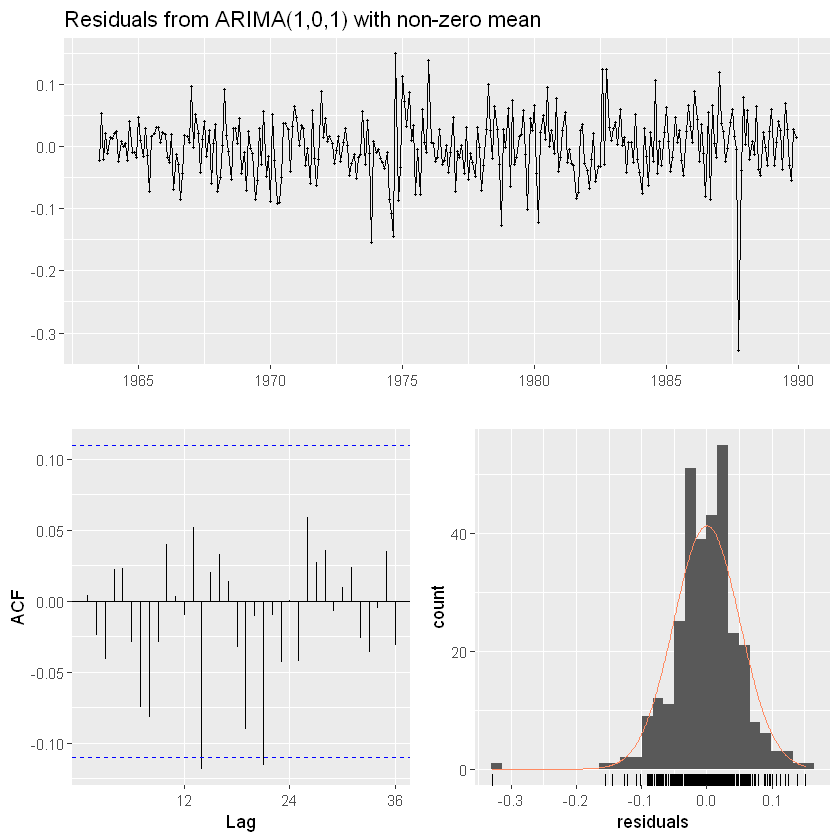

In [13]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(1,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [14]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [15]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-986.3786,-986.3405,-978.8545,5.061472
ARIMA001,-985.6949,-985.6184,-974.4087,5.053530
ARIMA002,-985.3807,-985.2529,-970.3325,5.038792
ARIMA100,-985.5027,-985.4262,-974.2165,5.054715
ARIMA101,-986.7537,-986.6259,-971.7055,5.025955
ARIMA102,-984.7624,-984.5701,-965.9521,5.026184
ARIMA200,-985.3007,-985.1729,-970.2525,5.039612
ARIMA201,-984.7614,-984.5691,-965.9512,5.026153
ARIMA202,-985.3831,-985.1130,-962.8108,5.002463


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 4.868333

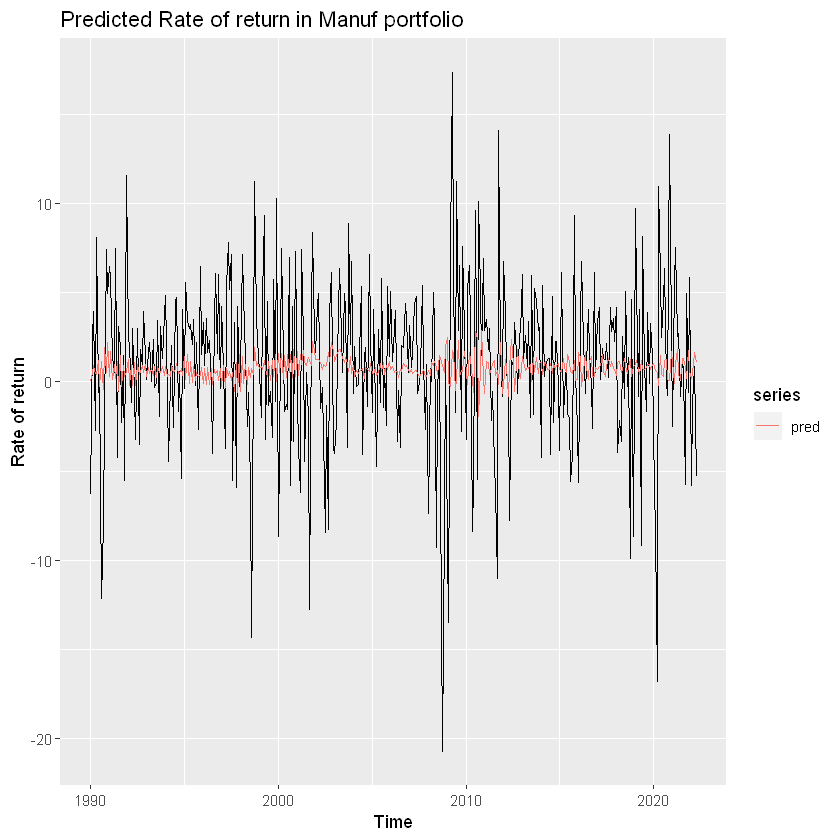

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Manuf portfolio")

In [9]:
as.numeric(pred)

[1]  0.02722220  0.47167587  0.91865251  0.48839959  0.41970860  1.17681580
  [7] -0.24368046  1.13865044 -0.44881178  1.95542024  0.50323050  2.23502883
 [13]  0.29876721  1.69712898  0.12363717  0.96181509  0.21238545  1.12470040
 [19] -0.45738883  1.46081271 -0.25278278  0.94615932  0.32316011  0.58739258
 [25]  1.25178934 -0.21106036  0.97520757 -0.18385030  1.09174169 -0.21225718
 [31]  0.99656302  0.41319934  0.59937867  0.91668925  0.53892886  0.95810585
 [37]  0.30549513  0.81947335  0.47667966  0.75038761  0.36880999  0.85223168
 [43]  0.26180886  0.88990802  0.51882367  0.52526966  0.87841553  0.36960684
 [49]  0.86565047  0.28291258  0.40286712  0.32692723  0.94553257  0.52430518
 [55]  0.67862925  1.00411007  0.45979600  0.49772819  0.73832034  0.38131951
 [61]  1.44601759  0.16013524  1.50933665 -0.06595102  1.13792602 -0.03853099
 [67]  0.84505251  0.05925006  0.53043198  0.30255617  0.33419573  0.81479052
 [73] -0.06068950  0.76399994 -0.12539383  0.79776692 -0.17075838  0.74141988
 [79] -0.17019963  0.69609117  0.45918109  0.63189947  0.09334074  0.72436887
 [85] -0.24250222  0.89820304 -0.31579987  0.73336185  0.36096854  0.58136785
 [91]  0.05984798  0.53988572 -0.51414710  1.09665562 -0.60936202  1.52680597
 [97] -0.51911436  1.39925224 -0.11141172  0.96130247 -0.16132736  0.79362809
[103]  0.22627314  0.75306026  0.39620928  1.92928914  0.89989686  1.02113927
[109]  0.72951129  0.84737687  0.71058169  1.20981287  0.67833450  0.29109746
[115]  1.12069991  0.07297827  1.18754025  0.28285463  1.54022901  0.01763477
[121]  1.60237027  0.51787424  1.56857630  0.14793454  1.46690035  0.22190624
[127]  1.55268284  0.51849125  1.55814760  0.24883580  1.82003383  0.30540923
[133]  1.68214278  0.33715269  1.54336694  0.99550659  1.74288010  1.15536250
[139]  0.90690261  1.37995964  1.18890080  0.92360905  2.28070712  1.77441002
[145]  1.28296337  1.27099518  1.26630310  1.08436579  0.67683203  0.99633606
[151]  0.86360559  0.89431014  1.65379174  1.15830780  2.21906854  1.77036805
[157]  1.15972997  1.49527782  1.61446372  1.79229821  1.81974414  1.36411811
[163]  1.08305399  1.35442159  1.01119287  0.58816050  1.44567209  0.48387186
[169]  0.90016208  0.28612218  0.63553013  0.44647066  0.58152477  0.69107255
[175]  0.77657884  0.21834056  0.82803518  0.68181746  0.58263954  1.02408885
[181]  0.44870133  0.41030064  0.79405545  0.35461416  0.55284528  1.05934709
[187]  0.61043609  1.10695551  0.39090301  0.94347023  0.68877936  1.14585913
[193]  0.68842458  0.86624999  0.50469971  0.66219458  0.57442432  0.26636323
[199]  0.72321671  0.57877486  1.00707060  0.86299135  0.90602130  0.70655570
[205]  0.53267778  0.69674476  0.49767263  0.58338807  0.65235444  0.51330054
[211]  0.22963593  0.40967674  0.49934205  0.67471669  0.32135415  0.30523560
[217]  0.66653909  0.37444203  1.10313656  0.93488935  1.15620468  0.82955411
[223]  0.41482347  1.45966320  1.12121581  0.91421549  0.54216206  1.98751691
[229]  2.50553620 -0.06524277 -0.26204235  1.75432612  1.63724505 -0.46154917
[235]  0.21958074  2.34299745  0.28686706  0.62750092  0.59207101  1.72392635
[241]  0.53499662 -0.13030596  1.65174990  1.29326523  0.15711082 -0.59479135
[247]  2.84708625  2.43480307 -1.93674881  0.70589027  2.86980428  0.26174346
[253] -0.64175396  1.15268132  1.06317505  0.42460109  0.73415705  1.04949888
[259]  1.19702558  0.38386226  0.61558380 -0.15346281  2.19643863 -0.62525650
[265] -0.20868084  1.25152796  0.86611984 -0.81033910  0.83059447  2.37508161
[271]  1.00268962 -0.54748449  0.98383598  1.82531334  0.34530406  0.19741387
[277]  1.40925857  1.13979714  0.66163918  0.79001590  0.72581022  0.99527081
[283]  0.04506048  1.34661986  0.61073924  1.39085212  0.45858389  1.04420385
[289]  1.08904900  0.42133876  1.00845998  1.13107280  0.71000654  0.66905688
[295]  1.04871911  0.46400768  1.03549351  0.67348867  0.90951738  1.02772437
[301]  0.70124591  0.54737181  1.28630191  0.79392058  0.53681765  1.56294291
[307]  1.11714868  0.556